# DivExplorer analysis - Example with COMPAS dataset 

In [1]:
%load_ext autoreload
%autoreload 2 

# Import dataset

In this running example we analyze the [COMPAS](https://www.propublica.org/article/how-we-analyzed-the-compas-recidivism-algorithm) dataset.

We import an already pre-processed and discretized version. You can refer to this [notebook](www.google.com) for its pre-processing.

The COMPAS dataset contains demographic information and the criminal history of defendants.
For each criminal defendant, the following attributes are available:
- *age_cat*: age category of the defendant. 
- *c_charge_degree*: severity of the charge. 'M'='Misdemeanor','F'='Felony' 
- *race*: 'Afr-Am', 'Asian', 'Cauc', 'Hispanic', 'Native American', 'Other'
- *sex*: 'Female', 'Male'
- *length_of_stay*: the days spent in jail, derived from the records of the date in which the person entered lastly the jail and the date in which the person was released.
- *priors_count*: the number of prior crimes committed.


For each defendant, the dataset also records:
- the *class*, whether the defendant recidivated (was arrested again) in the next two years. It is 1 if the defendant recidivated, 0 otherwise.
- the *predicted* recidivism, derived from the COMPAS score of recidivism risk assesses the defendant’s likelihood of committing another offense in a period of two years. It is 1 if the risk is high.

In [2]:
import os
inputDir=os.path.join(".", "notebooks", "datasets")

import pandas as pd
df = pd.read_csv(os.path.join(inputDir, "compas_discretized.csv"))
df.head()

,age,charge,race,sex,#prior,stay,class,predicted
0,>45,F,Other,Male,0,<week,0,0
1,25-45,F,Afr-Am,Male,0,1w-3M,1,0
2,<25,F,Afr-Am,Male,>3,<week,1,0
3,25-45,M,Other,Male,0,<week,0,0
4,25-45,F,Cauc,Male,>3,<week,1,0


In [3]:
# We take the true labels and the predicted labels
y_trues = df["class"].values
y_preds = df["predicted"].values

In [4]:
from divexplorer.outcomes import get_false_positive_rate_outcome

# We get the false positive rate outcome
# The value is 1 if the instance is a false positive, 0 is if it as a true negative, np.nan otherwise
# Please, see https://divexplorer.github.io/static/KDD_2021_DivExplorer.pdf for more details

df['fpr_outcome'] =  get_false_positive_rate_outcome(y_trues, y_preds, negative_value=0)

In [5]:
# We drop the columns that we do not need anymore
df = df.drop(columns=['class', 'predicted'])  

# Compute pattern divergence

With DivExplorer, we can compute the the performance metrics and the divergence scores of *all* itemsets whose frequency in the dataset is above a minimum frequency threshold (min_sup).

In [6]:
from divexplorer.divexplorer import DivergenceExplorer

min_sup = 0.1
fp_diver = DivergenceExplorer(df)

# We get the divergence patterns with a minimum support of 10%
# We set the outcomes to the name of the column that contains the outcome
# We can have multiple outcomes, but in this case we only have one

FP_fm = fp_diver.get_pattern_divergence(min_support=min_sup, boolean_outcomes = ['fpr_outcome'])
FP_fm.sort_values(by="support", ascending=False).head(10)

,support,itemset,fpr_outcome,fpr_outcome_div,fpr_outcome_t,length,support_count
0,1.000000,(),0.088314,0.000000,0.000000,0,6172.0
1,0.809624,(sex=Male),0.093810,0.005496,0.738697,1,4997.0
2,0.772683,(stay=<week),0.072043,-0.016271,2.339352,1,4769.0
3,0.643227,(charge=F),0.107754,0.019440,2.301183,1,3970.0
4,0.614226,"(stay=<week, sex=Male)",0.076379,-0.011935,1.555571,2,3791.0
5,0.572262,(age=25-45),0.088842,0.000528,0.087728,1,3532.0
6,0.532404,"(charge=F, sex=Male)",0.111041,0.022727,2.471729,2,3286.0
7,0.514420,(race=Afr-Am),0.139366,0.051052,5.046409,1,3175.0
8,0.471484,"(stay=<week, charge=F)",0.088179,-0.000135,0.016780,2,2910.0
9,0.460629,"(age=25-45, sex=Male)",0.096377,0.008063,0.914899,2,2843.0


The output is a pandas DataFrame. Each row represent a frequent pattern with the following information:

- support is the frequency of the pattern in the dataset
- itemset is the pattern - frozenset of items (str)
- fpr_outcome is the false positive rate of the pattern
- fpr_outcome_div is the divergence of the fpr = fpr(pattern) - fpr(all dataset)
- fpr_outcome_t is the the value of the fpr divergence
- lenght is the number of items in the pattern
- support_count is the number of instances that satisfy the pattern

In [8]:
# We sort the patterns by the false positive rat divergence
FP_fm.sort_values(by="fpr_outcome_div", ascending=False).head(5)

,support,itemset,fpr_outcome,fpr_outcome_div,fpr_outcome_t,length,support_count
112,0.128645,"(#prior=>3, age=25-45, race=Afr-Am, sex=Male)",0.308036,0.219722,7.116857,4,794.0
92,0.145010,"(#prior=>3, age=25-45, race=Afr-Am)",0.299242,0.210928,7.448260,3,895.0
135,0.109527,"(#prior=>3, age=25-45, charge=F, race=Afr-Am)",0.290155,0.201841,6.201585,4,676.0
109,0.130752,"(#prior=>3, charge=F, race=Afr-Am, sex=Male)",0.268722,0.180408,6.132988,4,807.0
67,0.175308,"(#prior=>3, race=Afr-Am, sex=Male)",0.266871,0.178557,7.214382,3,1082.0


## DivergencePatternProcessor - Analysis of the divergence patterns

In [10]:
from divexplorer.pattern_processor import DivergencePatternProcessor

# We create a pattern processor 
# We provide the dataframe and the name of the column that contains the outcome we want to analyze (fpr_outcome in this case)
fp_diver = DivergencePatternProcessor(FP_fm, 'fpr_outcome')

### Shapley value of a pattern divergence

In [11]:
# Given a pattern, we can get the shapley value of the pattern
pattern = fp_diver.patterns['itemset'].iloc[112]
print(pattern)

sv = fp_diver.shapley_value(pattern)
sv

frozenset({'#prior=>3', 'age=25-45', 'race=Afr-Am', 'sex=Male'})


{frozenset({'#prior=>3'}): 0.14226087371897317,
 frozenset({'age=25-45'}): 0.019084863062973356,
 frozenset({'race=Afr-Am'}): 0.05115538154975479,
 frozenset({'sex=Male'}): 0.007220590601649036}

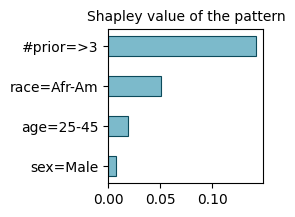

In [12]:
# We can also plot it

fp_diver.plot_shapley_value(pattern = pattern, figsize=(2,2), title="Shapley value of the pattern")

### Redundancy pruning

In [13]:
# We can prune the patterns that are redundant
# We keep only the patterns that are not redundant with a threshold of 0.05

fp_diver.redundancy_pruning(th_redundancy=0.05)

,support,itemset,length,support_count,fpr_outcome,fpr_outcome_div,fpr_outcome_t
0,1.000000,(),0,6172.0,0.088314,0.000000,0.000000
7,0.514420,(race=Afr-Am),1,3175.0,0.139366,0.051052,5.046409
28,0.293422,(#prior=>3),1,1811.0,0.219269,0.130955,7.503321
44,0.218244,(age=<25),1,1347.0,0.177066,0.088752,5.456070
47,0.209494,(age=>45),1,1293.0,0.027304,-0.061010,8.097262
65,0.177090,(stay=1w-3M),1,1093.0,0.151786,0.063472,3.668118


### Global Shapley value

In [15]:
# We can compute the global shapley value of the pattern divergence across all the patterns 
gsv = fp_diver.global_shapley_value()

For each (frequent) item, we compute its global divergence. 

The Global Shapley value is a generalization of the Shapley value to the entire set of all items. It captures the role of an item in giving rise to divergence jointly with other attributes.

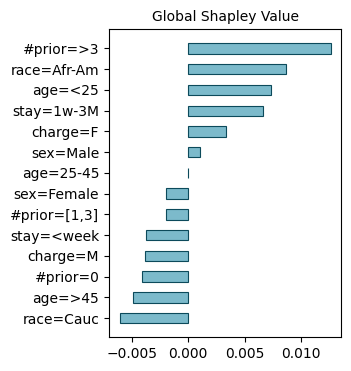

In [16]:
fp_diver.plot_shapley_value(shapley_values=gsv, figsize=(3,4), title='Global Shapley Value')

## Quantitative 

In [ ]:
import os
import numpy as np

inputDir=os.path.join(".", "notebooks", "datasets")

import pandas as pd
df= pd.read_csv(os.path.join(inputDir, "compas_discretized.csv"))

# This is just for test purposes
df['score'] = [np.random.uniform() for i in range(len(df))]
df.drop(columns=['class', 'predicted'], inplace=True)

In [ ]:
from divexplorer.divexplorer import DivergenceExplorer

min_sup = 0.1
fp_diver = DivergenceExplorer(
    df)
FP_fm = fp_diver.get_pattern_divergence(min_support=min_sup, quantitative_outcomes = ['score'], show_coincise = True)
FP_fm.sort_values(by="support", ascending=False).head(10)

In [ ]:
from divexplorer.pattern_processor import DivergencePatternProcessor

fp_diver = DivergencePatternProcessor(FP_fm, 'score')

pattern = fp_diver.patterns['itemset'].iloc[100]
print(pattern)

sv = fp_diver.shapley_value(pattern)
print(sv)
fp_diver.plot_shapley_value(shapley_values=sv, figsize=(2,2))

# Quantitative outcomes - multiple

In [ ]:
import os
inputDir=os.path.join(".", "notebooks", "datasets")

import pandas as pd
df = pd.read_csv(os.path.join(inputDir, "compas_discretized.csv"))
df.head()

In [ ]:
y_trues = df["class"].values
y_preds = df["predicted"].values

from divexplorer.outcomes import get_false_negative_rate_outcome, get_accuracy_outcome 


df['fnr_outcome'] = get_false_negative_rate_outcome(y_trues, y_preds, negative_value=0, positive_value=1)
df['acc_outcome'] = get_accuracy_outcome(y_trues, y_preds, negative_value=0, positive_value=1)

In [ ]:
df = df.drop(columns=['class', 'predicted'])  

In [ ]:
from divexplorer.divexplorer import DivergenceExplorer

min_sup = 0.1
fp_diver = DivergenceExplorer(
    df)
FP_fm = fp_diver.get_pattern_divergence(min_support=min_sup, boolean_outcomes = ['fnr_outcome', 'acc_outcome'], show_coincise = True)
FP_fm.sort_values(by="support", ascending=False).head(10)

In [ ]:
from divexplorer.pattern_processor import DivergencePatternProcessor

fp_diver = DivergencePatternProcessor(FP_fm, 'acc_outcome')

pattern = fp_diver.patterns['itemset'].iloc[30]
print(pattern)

fp_diver.plot_shapley_value(pattern = pattern, figsize=(2,2))

In [ ]:
gsv = fp_diver.global_shapley_value()
fp_diver.plot_shapley_value(shapley_values=gsv, figsize=(3,4), title='Global Shapley Value')